In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Optional

from pyscf import gto, scf, mcscf
import pyqmc.api as pyq

from qmc.pyscftools import orbital_evaluator_from_pyscf
from qmc.setting import initialize_calculation, determine_complex_settings
from qmc.mc import limdrift
from qmc.orbitals import *
from qmc.determinants import *
from qmc.extract import *

np.random.seed(42)
# jax.config.update("jax_enable_x64",True)

In [5]:
mol = gto.Mole()
mol.atom = '''
H 0.000000 0.000000 0.000000
H 0.000000 0.000000 0.740000
'''
mol.basis = 'sto-3g'
mol.build()

In [7]:
nconfig, seed = 10, 42
coords, max_orb, det_coeff, det_map, mo_coeff, occup_hash, _nelec, nelec = \
    initialize_calculation(mol, nconfig, seed)
iscomplex, mo_dtype, get_phase = \
    determine_complex_settings(mo_coeff, det_coeff)

converged SCF energy = -1.11675930739643


In [8]:
import time
start = time.time()
e = 0
epos = jnp.array(coords[:, e, :])
s = int(e >= _nelec[0])
# (φ ∂φ/∂x, ∂φ/∂y, ∂φ/∂z) -> (1, 4, config, number of coefficients)
aovals, dets, inverse = recompute(mol, coords, mo_coeff, _nelec, occup_hash)

start = time.time()

g, _, _  = gradient_value(mol, e, epos, dets, inverse, mo_coeff, det_coeff, det_map, _nelec, occup_hash)
end = time.time()
print(end - start)
print(g)

0.05313682556152344
[[ 0.01263103  0.98710936  1.074957   -0.43745238  0.9376929   0.81098807
  -0.4962658   1.0603508   0.53927296 -0.906228  ]
 [ 0.9898314  -0.1463075   0.5233616   0.51978856  0.34549594  0.8768676
   0.8852848  -0.33266783 -0.8766763  -0.32545635]
 [-0.0367953  -0.69546765 -0.08903468  1.0537777   0.08529682 -0.04201668
  -0.6944164   0.18497594 -0.42465436 -0.04018224]]


/opt/anaconda3/envs/qmc/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/qmc/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


In [9]:
from pyqmc.api import Slater
import pyscf
from pyscf import gto, scf, mcscf
from pyqmc.api import Slater
import pyqmc.api as pyq
import numpy as np
from pyqmc.api import vmc
from pyqmc.energy import kinetic
np.random.seed(42)
mf = scf.RHF(mol)
mf.kernel()
nconfig = 10
configs = pyq.initial_guess(mol, nconfig)

wf = Slater(mol, mf)
nconf, nelec, _ = configs.configs.shape
block_avg = {}
wf.recompute(configs)
e = 0

g, _, _ = wf.gradient_value(e, configs.electron(e))
end = time.time()
print(end - start)
g

converged SCF energy = -1.11675930739643
50.30373978614807


array([[ 0.01263103,  0.98710936,  1.07495699, -0.43745234,  0.93769286,
         0.81098804, -0.49626581,  1.06035087,  0.53927291, -0.90622795],
       [ 0.9898314 , -0.14630749,  0.52336155,  0.51978857,  0.34549593,
         0.87686757,  0.88528481, -0.33266788, -0.87667629, -0.32545636],
       [-0.03679529, -0.69546761, -0.08903469,  1.05377761,  0.0852968 ,
        -0.04201668, -0.69441644,  0.18497596, -0.42465425, -0.04018222]])

In [10]:

aovals, dets, inverse = recompute(mol, coords, mo_coeff, _nelec, occup_hash)
tstep = 0.5
nconf, nelec, _ = coords.shape

e = 0
g, _, _  = gradient_value(mol, e, coords[:, e, :], dets, inverse, mo_coeff, \
                            det_coeff, det_map, _nelec, occup_hash)
grad = limdrift(jnp.real(g.T))


gauss = np.random.normal(scale=np.sqrt(tstep), size=(nconf, 3))
gauss = jnp.array(gauss)
newcoorde = coords[:, e, :] + gauss + grad * tstep

# pbc -> make_irreducible -> Not yet
g, new_val, saved = gradient_value(mol, e, newcoorde, dets, inverse, mo_coeff, \
                                    det_coeff, det_map, _nelec, occup_hash)

new_grad = limdrift(jnp.real(g.T))

forward = jnp.sum(gauss**2, axis = 1)
backward = jnp.sum((gauss + tstep * (grad + new_grad))**2, axis = 1)
t_prob = jnp.exp(1 / (2 * tstep) * (forward - backward))

ratio = jnp.abs(new_val) ** 2 * t_prob
accept = ratio > np.random.rand(nconf)
coords[accept, e, :] = newcoorde[accept, :]
jnp.where(accept)[0]
aovals, dets, inverse = sherman_morrison(e, newcoorde, coords, mask = accept, aovals = aovals, saved_value= saved, get_phase = get_phase, dets = dets, inverse = inverse, mo_coeff = mo_coeff, occup_hash = occup_hash, _nelec = _nelec)
print(dets)
print("----------")
print(inverse)
print("----------")
print(aovals)

(Array([[[ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ]],

       [[-1.611407 ],
        [-3.1173074],
        [-2.0231225],
        [-1.8497576],
        [-1.3727323],
        [-1.5827291],
        [-2.04212  ],
        [-1.3611326],
        [-2.018077 ],
        [-1.944516 ]]], dtype=float32), Array([[[ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ],
        [ 1.       ]],

       [[-2.2652853],
        [-1.1152118],
        [-3.2495644],
        [-1.8739737],
        [-1.7962711],
        [-2.7021296],
        [-2.3944097],
        [-1.5057076],
        [-1.6312922],
        [-2.0438063]]], dtype=float32))
----------
(Array([[[[ 5.009856 ]]],


       [[[22.585484 ]]],


       [[[ 7.

In [12]:
wf.recompute(configs)
e = 0
g, _, _ = wf.gradient_value(e, configs.electron(e))
grad = limdrift(np.real(g.T))
gauss = np.random.normal(scale=np.sqrt(tstep), size=(nconf, 3))
newcoorde = configs.configs[:, e, :] + gauss + grad * tstep
newcoorde = configs.make_irreducible(e, newcoorde)

# Compute reverse move
g, new_val, saved = wf.gradient_value(e, newcoorde)
new_grad = limdrift(np.real(g.T))
forward = np.sum(gauss**2, axis=1)
backward = np.sum((gauss + tstep * (grad + new_grad)) ** 2, axis=1)

# Acceptance
t_prob = np.exp(1 / (2 * tstep) * (forward - backward))
ratio = np.abs(new_val) ** 2 * t_prob
accept = ratio > np.random.rand(nconf)
# Update wave function
configs.move(e, newcoorde, accept)
wf.updateinternals(e, newcoorde, configs, mask=accept, saved_values=saved)

In [5]:
np.random.seed(seed)
key = random.PRNGKey(seed)
coords = configs.configs
nsteps = 1000
tstep = 0.5
nconf, nelec, _ = coords.shape

dets, inverse, aovals = recompute(mol, coords, mo_coeff, _nelec, occup_hash)

equilibration_step = 800


for i in range(equilibration_step):
    acc = 0
        
    for e in range(nelec):
        g, _, _  = gradient_value(mol, e, coords[:, e, :], dets, inverse, mo_coeff, \
                                  det_coeff, det_map, _nelec, occup_hash)
        grad = limdrift(jnp.real(g.T))
        
        
        gauss = np.random.normal(scale=np.sqrt(tstep), size=(nconf, 3))
        gauss = jnp.array(gauss)
        newcoorde = coords[:, e, :] + gauss + grad * tstep
        
        # pbc -> make_irreducible -> Not yet
        g, new_val, saved = gradient_value(mol, e, newcoorde, dets, inverse, mo_coeff, \
                                           det_coeff, det_map, _nelec, occup_hash)
        
        new_grad = limdrift(jnp.real(g.T))
        
        forward = jnp.sum(gauss**2, axis = 1)
        backward = jnp.sum((gauss + tstep * (grad + new_grad))**2, axis = 1)
        t_prob = jnp.exp(1 / (2 * tstep) * (forward - backward))

        ratio = jnp.abs(new_val) ** 2 * t_prob
        accept = ratio > np.random.rand(nconf)
        coords[accept, e, :] = newcoorde[accept, :]
        aovals, dets, inverse = sherman_morrison(e, newcoorde, coords, mask = accept, gtoval = "GTOval_sph", aovals = aovals, saved_value= saved, get_phase = get_phase, dets = dets, inverse = inverse, mo_coeff = mo_coeff, occup_hash = occup_hash, _nelec = _nelec)
        
        acc += jnp.mean(accept) / nelec
print(acc)

0.52000004


In [22]:
import pyscf
from pyscf import gto, scf, mcscf
from pyqmc.api import Slater
import pyqmc.api as pyq
import numpy as np
from pyqmc.api import vmc
from pyqmc.energy import kinetic

def limdrift(g, cutoff=1):
    """
    Limit a vector to have a maximum magnitude of cutoff while maintaining direction

    :parameter g: a [nconf,ndim] vector
    :parameter cutoff: the maximum magnitude
    :returns: The vector with the cutoff applied.
    """
    tot = np.linalg.norm(g, axis=1)
    mask = tot > cutoff
    g[mask, :] = cutoff * g[mask, :] / tot[mask, np.newaxis]
    return g

# 물 분자 정의
np.random.seed(42)

mol = gto.Mole()
mol.atom = '''
O 0.000000 0.000000 0.117790
H 0.000000 0.755453 -0.471161
H 0.000000 -0.755453 -0.471161
'''
mol.basis = 'sto-3g'
mol.build()

mf = scf.RHF(mol)
mf.kernel()

nconfig = 10
configs = pyq.initial_guess(mol, nconfig)

wf = Slater(mol, mf)
nconf, nelec, _ = configs.configs.shape
block_avg = {}
wf.recompute(configs)
nsteps = 1
tstep = 0.5
equilibration_step = 800

np.random.seed(42)

for _ in range(equilibration_step):
    acc2 = 0.0
    for e in range(nelec):
        # Propose move
        g, _, _ = wf.gradient_value(e, configs.electron(e))
        grad = limdrift(np.real(g.T))
        gauss = np.random.normal(scale=np.sqrt(tstep), size=(nconf, 3))
        newcoorde = configs.configs[:, e, :] + gauss + grad * tstep
        newcoorde = configs.make_irreducible(e, newcoorde)

        # Compute reverse move
        g, new_val, saved = wf.gradient_value(e, newcoorde)
        new_grad = limdrift(np.real(g.T))
        forward = np.sum(gauss**2, axis=1)
        backward = np.sum((gauss + tstep * (grad + new_grad)) ** 2, axis=1)

        # Acceptance
        t_prob = np.exp(1 / (2 * tstep) * (forward - backward))
        ratio = np.abs(new_val) ** 2 * t_prob
        accept = ratio > np.random.rand(nconf)
        # Update wave function
        configs.move(e, newcoorde, accept)
        wf.updateinternals(e, newcoorde, configs, mask=accept, saved_values=saved)
        acc2 += np.mean(accept) / nelec
print("jaejun_qmc result is" ,acc)
print("pyqmc result is", acc2)

converged SCF energy = -74.963146775618
jaejun_qmc result is 0.52
pyqmc result is 0.52


In [8]:
production_steps = 4000
energies = []
for i in range(production_steps):
    acc = 0
    for e in range(nelec):
        g, _, _ = gradient_value(mol, e, coords[:, e, :], dets, inverse, mo_coeff,
                                det_coeff, det_map, _nelec, occup_hash)
        grad = limdrift(jnp.real(g.T))
        gauss = np.random.normal(scale=np.sqrt(tstep), size=(nconf, 3))
        gauss = jnp.array(gauss)
        newcoorde = coords[:, e, :] + gauss + grad * tstep
        
        g, new_val, saved = gradient_value(mol, e, newcoorde, dets, inverse, mo_coeff,
                                         det_coeff, det_map, _nelec, occup_hash)
        
        new_grad = limdrift(jnp.real(g.T))
        
        forward = jnp.sum(gauss**2, axis=1)
        backward = jnp.sum((gauss + tstep * (grad + new_grad))**2, axis=1)
        t_prob = jnp.exp(1/(2 * tstep) * (forward - backward))
        
        ratio = jnp.abs(new_val)**2 * t_prob
        accept = ratio > np.random.rand(nconf)
        coords[accept, e, :] = newcoorde[accept, :]
        
        aovals, dets, inverse = sherman_morrison(e, newcoorde, coords, mask=accept,
                                               gtoval="GTOval_sph", aovals=aovals,
                                               saved_value=saved, get_phase=get_phase,
                                               dets=dets, inverse=inverse,
                                               mo_coeff=mo_coeff, occup_hash=occup_hash,
                                               _nelec=_nelec)
        
        acc += jnp.mean(accept) / nelec
    
    PE = compute_potential_energy(mol, coords)
    KE, _  = kinetic_energy(coords, mol, dets, inverse, mo_coeff, 
                            det_coeff, det_map, _nelec, occup_hash)

    energies.append({
        'ee': PE['ee'],
        'ei': PE['ei'],
        'ii': PE['ii'],
        'ke': KE,
        'total': PE['total'] + KE,
        'accept_ratio': acc
    })

energies = jnp.array([e['total'] for e in energies])
mean_energy = jnp.mean(energies)
std_energy = jnp.std(energies)
print(f"Mean total energy: {mean_energy:.6f} ± {std_energy:.6f}")

Mean total energy: -73.312520 ± 19.631363


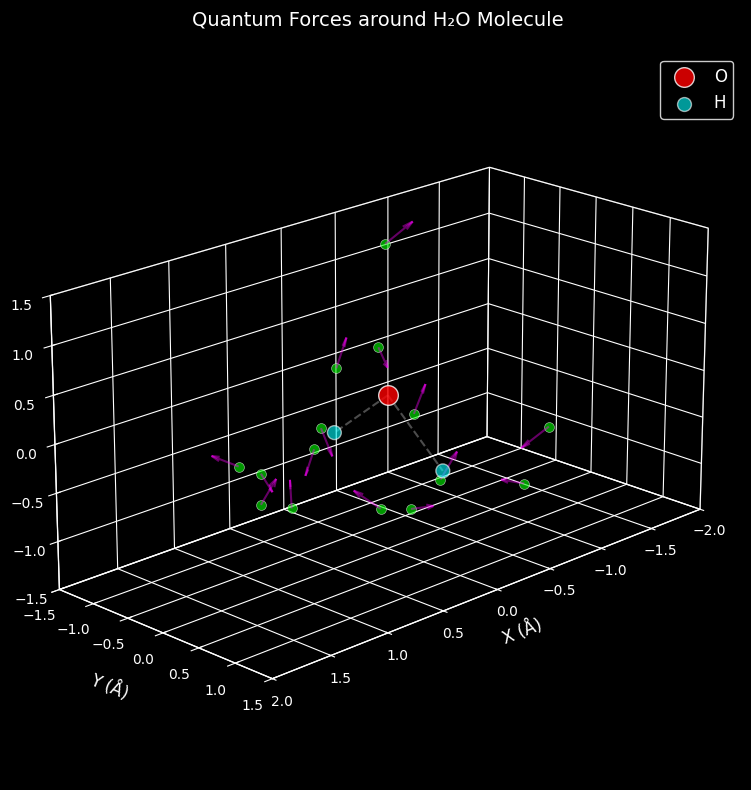

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 스타일 설정
plt.style.use('dark_background')

# 물분자 원자 좌표
atoms = np.array([
   [0.0, 0.0, 0.117790],  # O
   [0.0, 0.755453, -0.471161],  # H
   [0.0, -0.755453, -0.471161]  # H
])

# 임의의 전자 위치 (15개)
np.random.seed(42)
electrons = np.random.randn(15, 3) * 0.8

# 임의의 quantum force 
quantum_force = np.random.randn(15, 3) * 0.5

# 3D plot - 가로로 더 긴 figure 크기
fig = plt.figure(figsize=(16, 8), facecolor='black')
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')

# 원자 표시
ax.scatter(atoms[0,0], atoms[0,1], atoms[0,2], 
         c='red', s=200, alpha=0.8, label='O',
         edgecolors='white', linewidth=1)
ax.scatter(atoms[1:,0], atoms[1:,1], atoms[1:,2], 
         c='cyan', s=100, alpha=0.6, label='H',
         edgecolors='white', linewidth=1)

# 분자 결합 표시
for i in range(1, 3):
   ax.plot([atoms[0,0], atoms[i,0]], 
           [atoms[0,1], atoms[i,1]], 
           [atoms[0,2], atoms[i,2]], 
           'w--', alpha=0.3)

# 전자와 quantum force 표시
for i in range(len(electrons)):
   pos = electrons[i]
   force = quantum_force[i]
   
   ax.scatter(pos[0], pos[1], pos[2], 
             c='lime', s=50, alpha=0.6,
             edgecolors='white', linewidth=0.5)
   
   ax.quiver(pos[0], pos[1], pos[2], 
            force[0], force[1], force[2],
            color='magenta', alpha=0.4,
            length=0.3, normalize=True,
            arrow_length_ratio=0.3)

# 축 레이블
ax.set_xlabel('X (Å)', fontsize=12, labelpad=10)
ax.set_ylabel('Y (Å)', fontsize=12, labelpad=10)
ax.set_zlabel('Z (Å)', fontsize=12, labelpad=10)

# 그리드와 배경
ax.grid(True, linestyle='--', alpha=0.2)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# 범례
ax.legend(fontsize=12, loc='upper right', 
        facecolor='black', edgecolor='white', framealpha=0.8)

plt.title('Quantum Forces around H₂O Molecule', 
        fontsize=14, pad=20, color='white')

# 시점 조정
ax.view_init(elev=20, azim=45)

# 축 범위 조정 - 가로 방향으로 더 넓게
ax.set_box_aspect([2,1,1])  # 가로:세로:높이 비율
lim_x = 2.0  # x축 범위를 더 넓게
lim_yz = 1.5  # y, z축 범위
ax.set_xlim(-lim_x, lim_x)
ax.set_ylim(-lim_yz, lim_yz)
ax.set_zlim(-lim_yz, lim_yz)

plt.tight_layout()

# 저장
plt.savefig('quantum_forces_h2o_wide.png', dpi=300, bbox_inches='tight', facecolor='black')
plt.savefig('quantum_forces_h2o_wide.pdf', bbox_inches='tight', facecolor='black')
plt.savefig('quantum_forces_h2o_wide.svg', bbox_inches='tight', facecolor='black')

plt.show()